<p align="center"><b>Apple Music Annual Wrap Artist-Related Data Analysis</b></p>

<p align="center">Hanjian Xu</p>
<p align="center">May 2025</p>

---

## Goal
To create another dataframe with the focus on artists using the finalized `final_am_dataset_tableau.csv`.

- Expand the `artist_list` column to isolate individual artists. Preserve certain columns (year, month, album) to allow aggreagated summary stats in Tableau.

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import ast

import warnings

# load in data
df = pd.read_csv('data/final_am_dataset_tableau.csv', encoding = "utf-8-sig")

df.shape

(164038, 33)

In [3]:
df['artist_list']

0                  ['Camila Cabello', 'Nicholas Galitzine']
1         ['Camila Cabello', 'Idina Menzel', 'Cinderella...
2         ['Camila Cabello', 'Idina Menzel', 'Cinderella...
3         ['Idina Menzel', 'Cinderella Original Motion P...
4         ['Idina Menzel', 'Cinderella Original Motion P...
                                ...                        
164033    ['Michael Giacchino', 'Tim Simonec', 'Hollywoo...
164034    ['Michael Giacchino', 'Tim Simonec', 'Hollywoo...
164035                                 ['cxlt.', 'squeeda']
164036                                   ['Echoes Of Time']
164037                                   ['Kelly Clarkson']
Name: artist_list, Length: 164038, dtype: object

In [4]:
# Expand the artist list column

# Proper eval the artist_list
df['artist_list'] = df['artist_list'].apply(ast.literal_eval)

# Convert timestamp once and pull out year & month
df['event_dt'] = pd.to_datetime(df['event_start_timestamp'])
df['year']     = df['event_dt'].dt.year
df['month']    = df['event_dt'].dt.to_period('M')
df['weekday']  = df['event_dt'].dt.day_name()
df['hour']     = df['event_dt'].dt.hour

# Explode artists into separate rows
df_flat = (
    df
    .explode('artist_list', ignore_index = True) # now each artist has its own row
    .rename(columns={'artist_list': 'artist'}) 
    [['artist','play_duration_milliseconds','year','month', 'weekday','hour', 'album_name', 'category']]
    .rename(columns={'play_duration_milliseconds':'duration'})
)

df_flat.head()


/var/folders/tr/xh05sl9s3q171cth46cr9vnw0000gn/T/ipykernel_83008/2478324521.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month']    = df['event_dt'].dt.to_period('M')


,artist,duration,year,month,weekday,hour,album_name,category
0,Camila Cabello,77926,2021,2021-09,Wednesday,12,Cinderella (Soundtrack from the Amazon Origina...,Soundtrack
1,Nicholas Galitzine,77926,2021,2021-09,Wednesday,12,Cinderella (Soundtrack from the Amazon Origina...,Soundtrack
2,Camila Cabello,168506,2024,2024-05,Sunday,2,Cinderella (Soundtrack from the Amazon Origina...,Soundtrack
3,Idina Menzel,168506,2024,2024-05,Sunday,2,Cinderella (Soundtrack from the Amazon Origina...,Soundtrack
4,Cinderella Original Motion Picture Cast,168506,2024,2024-05,Sunday,2,Cinderella (Soundtrack from the Amazon Origina...,Soundtrack


In [5]:
print(df_flat.isna().sum())
artist_df = df_flat.copy()

artist         0
duration       0
year           0
month          0
weekday        0
hour           0
album_name    28
category       0
dtype: int64


In [7]:
artist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214413 entries, 0 to 214412
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype    
---  ------      --------------   -----    
 0   artist      214413 non-null  object   
 1   duration    214413 non-null  int64    
 2   year        214413 non-null  int32    
 3   month       214413 non-null  period[M]
 4   weekday     214413 non-null  object   
 5   hour        214413 non-null  int32    
 6   album_name  214385 non-null  object   
 7   category    214413 non-null  object   
dtypes: int32(2), int64(1), object(4), period[M](1)
memory usage: 11.5+ MB


In [ ]:
artist_df.head()
artist_df['play_duration_min'] = artist_df['duration']/60000
artist_df.shape()

To double check if the total row number of artist_df is accurate:

Distribution of songs by number of artists:
num_artists
1     137189
2      16612
3       5576
4       1282
5       1898
6        223
7         94
8        422
9        524
10       112
11        32
12         3
13        11
15        45
16        15
Name: count, dtype: int64

Percentages:
1 artist: 137189 songs (83.63%)
2 artists: 16612 songs (10.13%)
3 artists: 5576 songs (3.4%)
4 artists: 1282 songs (0.78%)
5 artists: 1898 songs (1.16%)
6 artists: 223 songs (0.14%)
7 artists: 94 songs (0.06%)
8 artists: 422 songs (0.26%)
9 artists: 524 songs (0.32%)
10 artists: 112 songs (0.07%)
11 artists: 32 songs (0.02%)
12 artists: 3 songs (0.0%)
13 artists: 11 songs (0.01%)
15 artists: 45 songs (0.03%)
16 artists: 15 songs (0.01%)


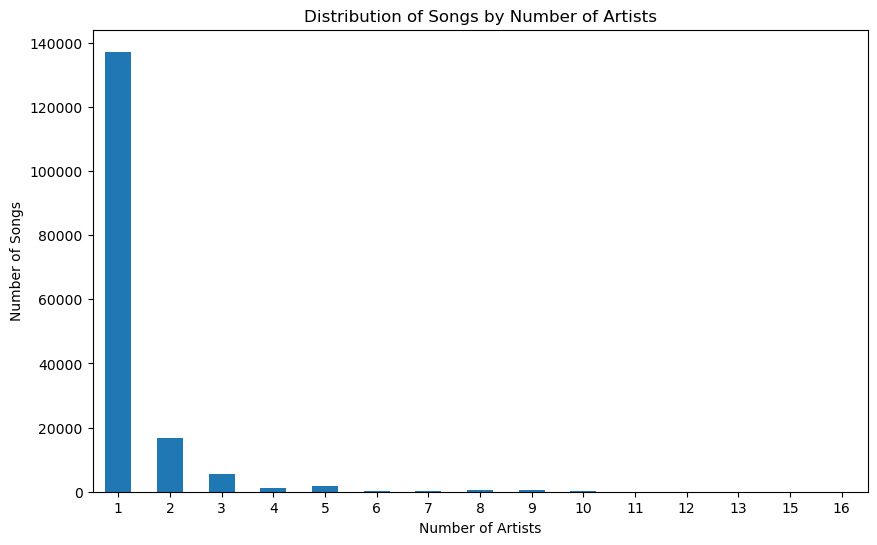

In [ ]:
# Count number of artists per song
df['num_artists'] = df['artist_list'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Get distribution of songs by number of artists
artist_distribution = df['num_artists'].value_counts().sort_index()

# Display the distribution
print("Distribution of songs by number of artists:")
print(artist_distribution)

# Viz
plt.figure(figsize=(10, 6))
artist_distribution.plot(kind='bar')
plt.title('Distribution of Songs by Number of Artists')
plt.xlabel('Number of Artists')
plt.ylabel('Number of Songs')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Expected row number:
total_artist_entries = pd.Series(artist_distribution.index * artist_distribution.values).sum()
print(total_artist_entries)

214413


Some simple top artist play duration analysis:

In [ ]:
# Group by year and artist, sum durations
yearly_artist_durations = artist_df.groupby(['year', 'artist'])['duration'].sum().reset_index()
monthly_artist_durations = artist_df.groupby(['month', 'artist'])['duration'].sum().reset_index()

# Convert duration from ms to hrs
yearly_artist_durations['duration_hours'] = yearly_artist_durations['duration'] / (1000 * 60 * 60)
monthly_artist_durations['duration_hours'] = monthly_artist_durations['duration'] / (1000 * 60 * 60)

# sort by time and duration
yearly_artist_durations = yearly_artist_durations.sort_values(['year', 'duration_hours'], ascending=[True, False])
monthly_artist_durations = monthly_artist_durations.sort_values(['month', 'duration_hours'], ascending=[True, False])

# display top 10 artists for each year
topn = 10
for year in range(2024, 2026):

    print(f"\nTop {topn} Artists for {year}:")
    year_data = yearly_artist_durations[yearly_artist_durations['year'] == year].head(topn)
    print(year_data[['artist', 'duration_hours']].to_string(index=False))



Top 10 Artists for 2024:
           artist  duration_hours
Sabrina Carpenter      187.169065
     Mariah Carey      156.213146
    Ariana Grande      153.808552
              焦迈奇      129.791064
Siddhartha Khosla       83.408034
         Dua Lipa       77.369543
      Brian Tyler       70.366253
       Bruno Mars       64.527692
     Idina Menzel       55.546084
        Lady Gaga       54.733091

Top 10 Artists for 2025:
          artist  duration_hours
     Jung Jae Il       91.239593
             孫燕姿       57.240547
   Ariana Grande       37.922808
   Sung Si Kyung       25.289303
   Billie Eilish       15.813911
Theodore Shapiro       15.163131
     CeCe Rogers       14.827878
    David Guetta       14.827878
    James Horner       14.169590
          Disney       13.090082


In [ ]:
# for month:
topn = 10
for month in artist_df['month'].unique():

    print(f"\nTop {topn} Artists for {month}:")
    month_data = monthly_artist_durations[monthly_artist_durations['month'] == month].head(topn)
    print(month_data[['artist', 'duration_hours']].to_string(index=False))



Top 10 Artists for 2021-09:
                                    artist  duration_hours
   Cinderella Original Motion Picture Cast       18.691171
                              Idina Menzel       16.961154
                              Mariah Carey       15.221769
                                 Ben Platt       13.706825
                            Camila Cabello       13.181242
Original Broadway Cast of Dear Evan Hansen        8.678228
                               Hans Zimmer        8.627300
                               Alan Menken        7.660846
                             Thomas Newman        6.239582
                             Frank Ricotti        6.181055

Top 10 Artists for 2024-05:
             artist  duration_hours
  Michael Giacchino       24.761061
           Dua Lipa       16.372584
James Newton Howard       13.069615
               飛兒樂團       11.217407
        Brian Tyler       10.248105
                 老狼        8.245152
       Mariah Carey        7.796572
    A

Save the artist_data as a secondary data source for tableau viz.

In [ ]:
artist_df.to_csv('data/artist_duration_data.csv', encoding="utf-8-sig")

In [ ]:
# Stream duration by weekdays

weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

artist_df['weekday'] = pd.Categorical(
    artist_df['weekday'],
    categories=weekday_order,
    ordered=True
)

top_artists_per_weekday = (
    artist_df
    .groupby('weekday')['artist']
    .value_counts()
    .groupby(level=0, group_keys=False)  # group by 'weekday' again
    .nlargest(5)
    .reset_index(name='count')
)

top_artists_per_weekday

/var/folders/tr/xh05sl9s3q171cth46cr9vnw0000gn/T/ipykernel_32350/1500040923.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('weekday')['artist']
/var/folders/tr/xh05sl9s3q171cth46cr9vnw0000gn/T/ipykernel_32350/1500040923.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0, group_keys=False)  # group by 'weekday' again


,weekday,artist,count
0,Sunday,Mariah Carey,2704
1,Sunday,Ariana Grande,976
2,Sunday,Siddhartha Khosla,899
3,Sunday,Sabrina Carpenter,586
4,Sunday,James Newton Howard,521
5,Monday,Mariah Carey,2206
6,Monday,Siddhartha Khosla,1968
7,Monday,Hans Zimmer,1066
8,Monday,Brian Tyler,932
9,Monday,Michael Giacchino,747
